In [1]:
import src.paths

In [2]:
date = '2022-09-16'

In [3]:
%%time
spikes_raw = pd.read_pickle(src.paths.DATA / date / f'{date}-hpc-spikes.pkl')

CPU times: user 3.92 ms, sys: 666 ms, total: 670 ms
Wall time: 6.41 s


In [4]:
%%time
csd_raw = pd.read_pickle(src.paths.DATA / date / f'{date}-hpc-csd.pkl')

CPU times: user 0 ns, sys: 3.03 s, total: 3.03 s
Wall time: 28.8 s


---

In [45]:
start = 300 # start time in seconds
end = 1500  # end time in seconds
MAX_THETA = 15 # shortest allowed theta frame in Hz
MIN_THETA = 2  # longest allowed theta frame in Hz

In [54]:
spikes = spikes_raw.loc[start:end - 1 / 250, 160:163]
csd = csd_raw.loc[start:end - 1 / 1250, 40]

In [55]:
Qs = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
Fs = [2, 4, 6, 8, 10, 12, 14, 16]

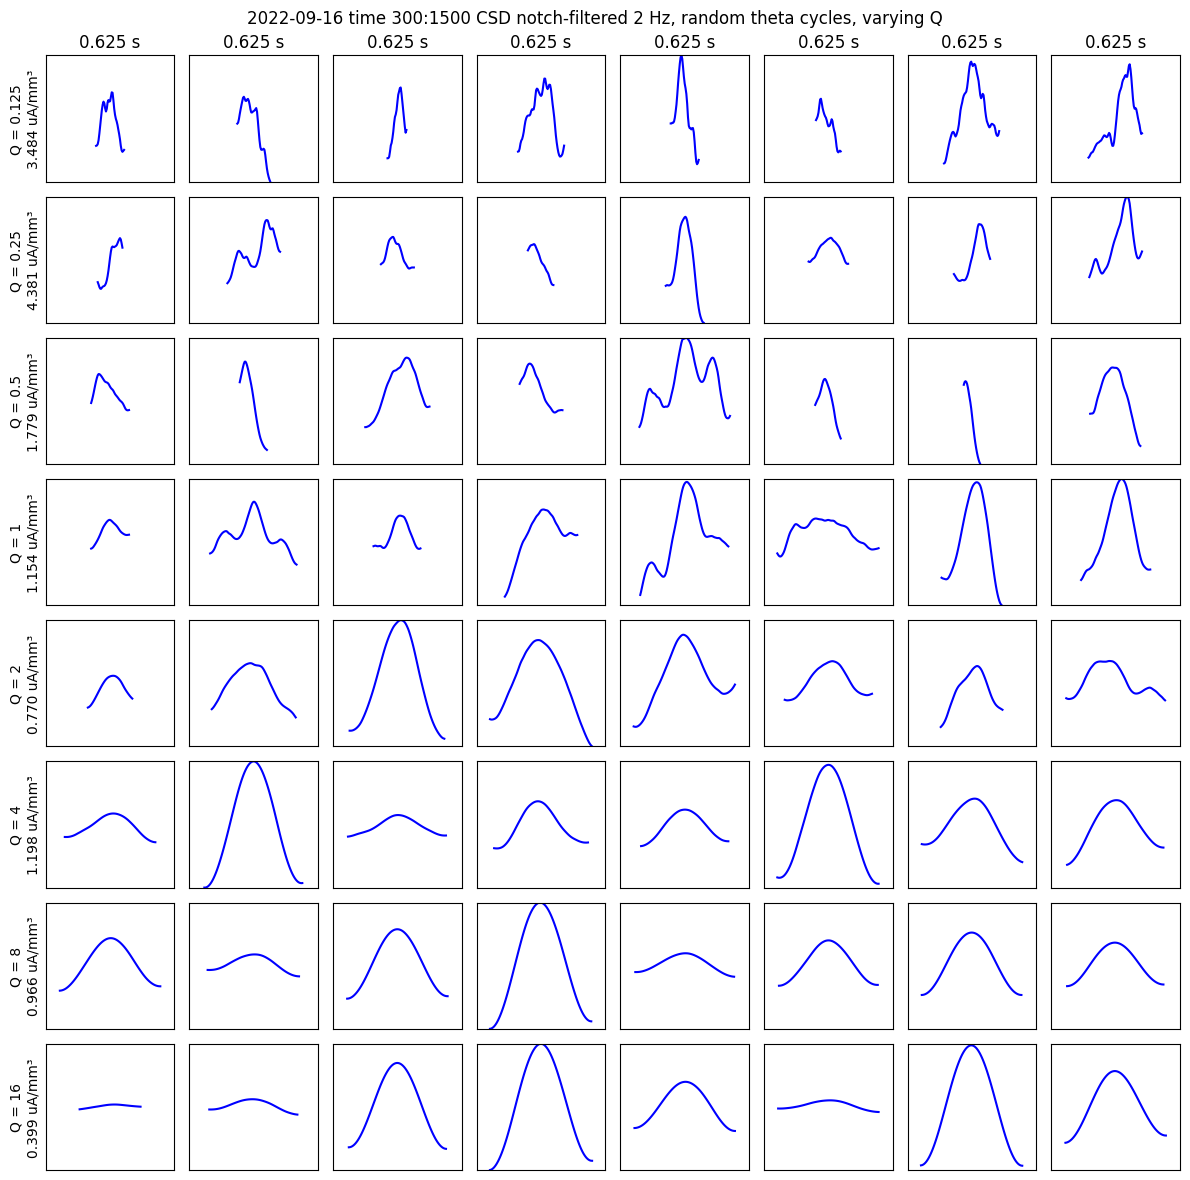

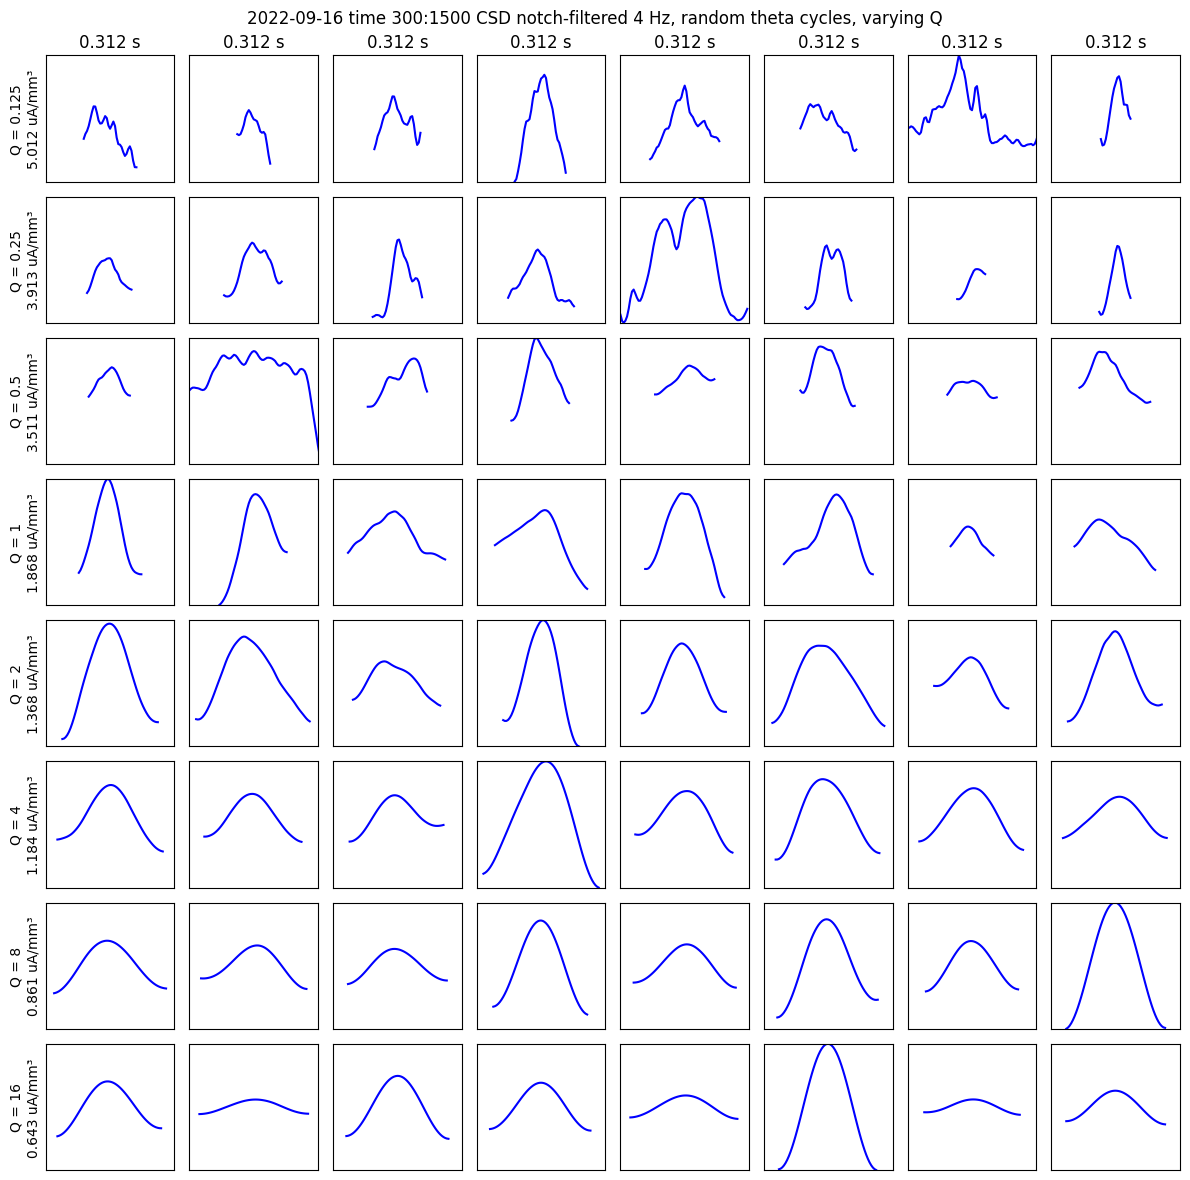

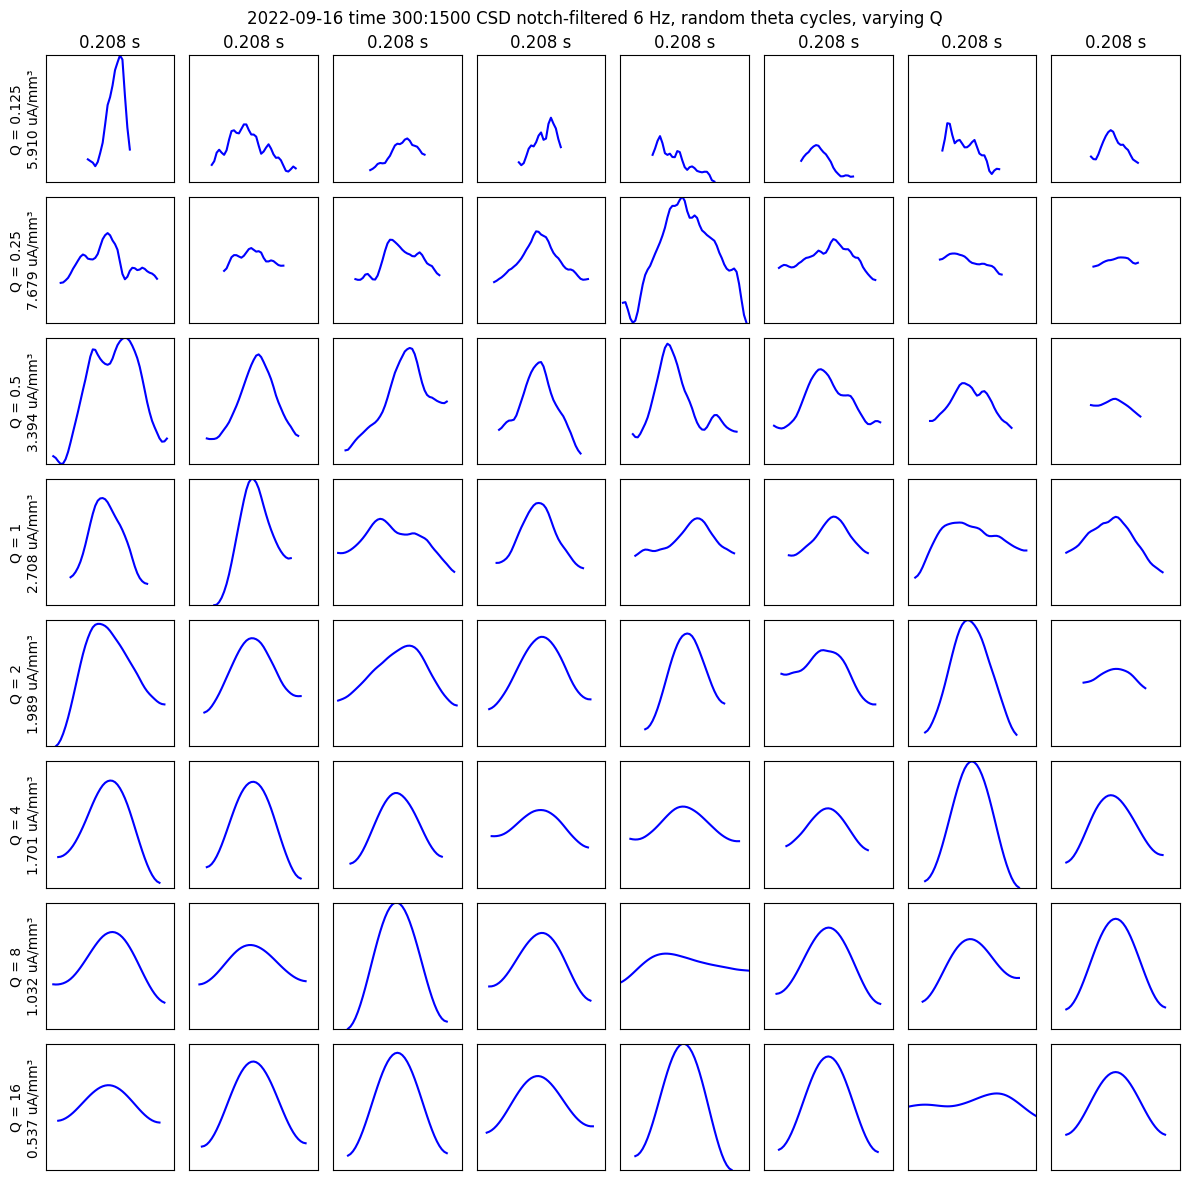

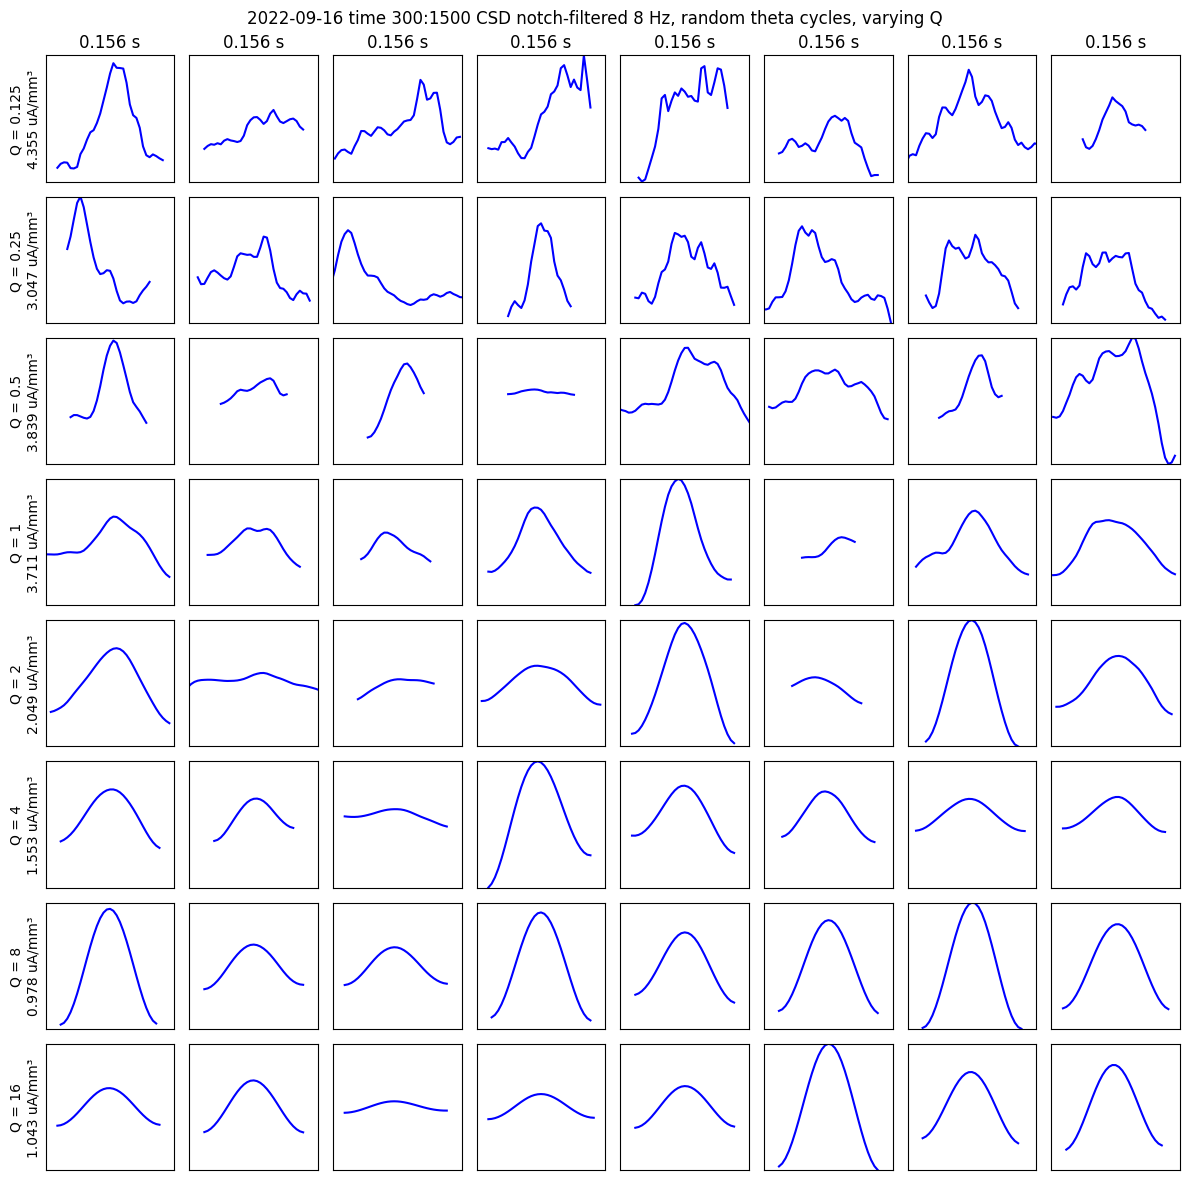

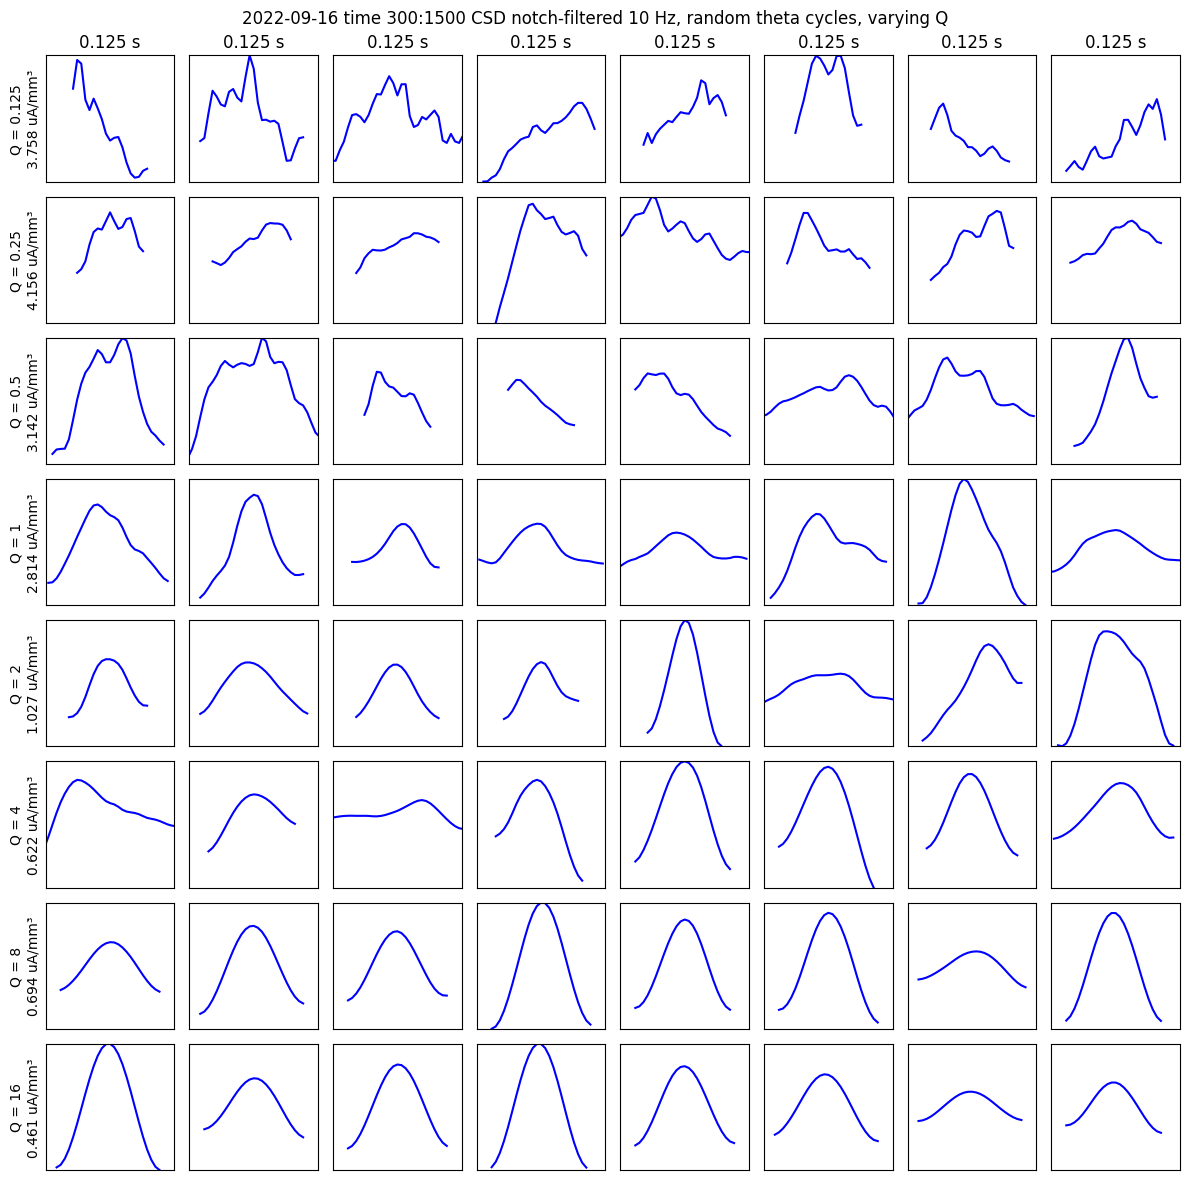

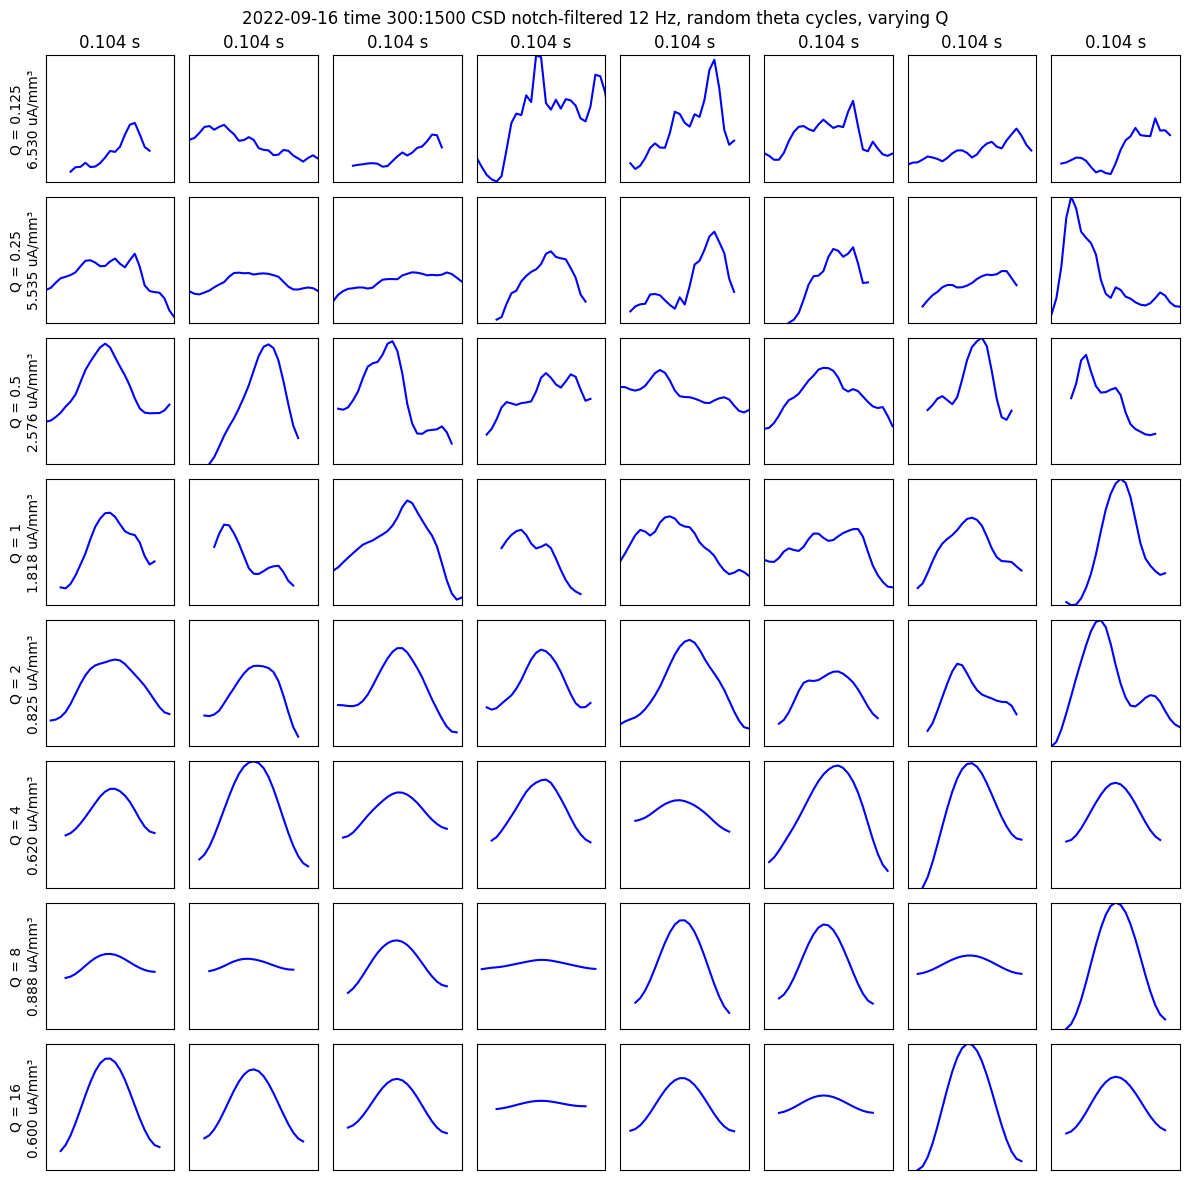

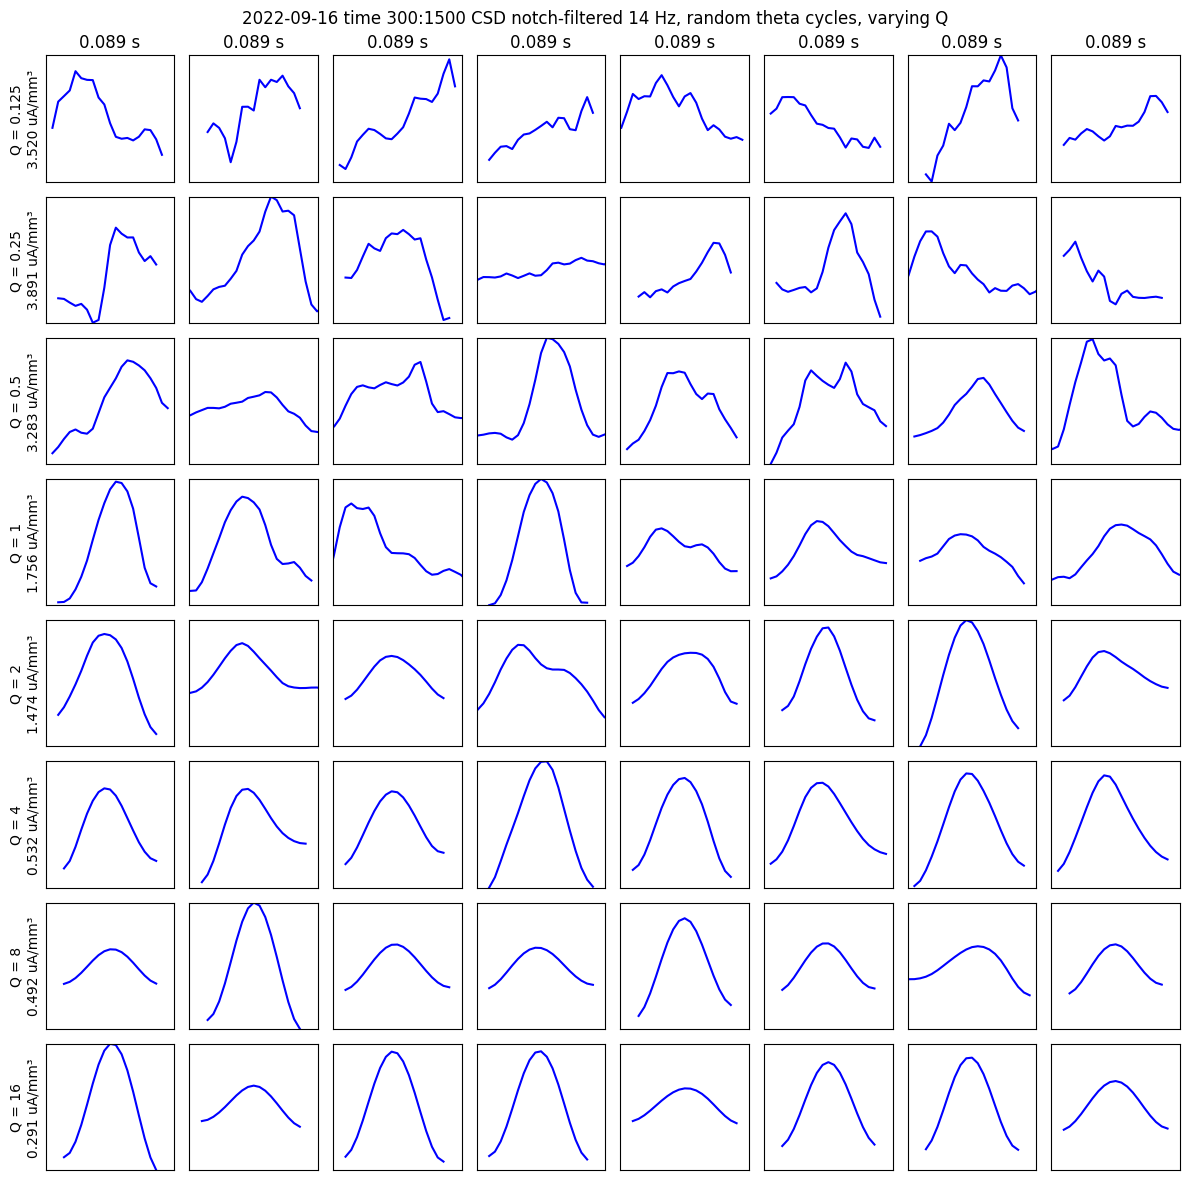

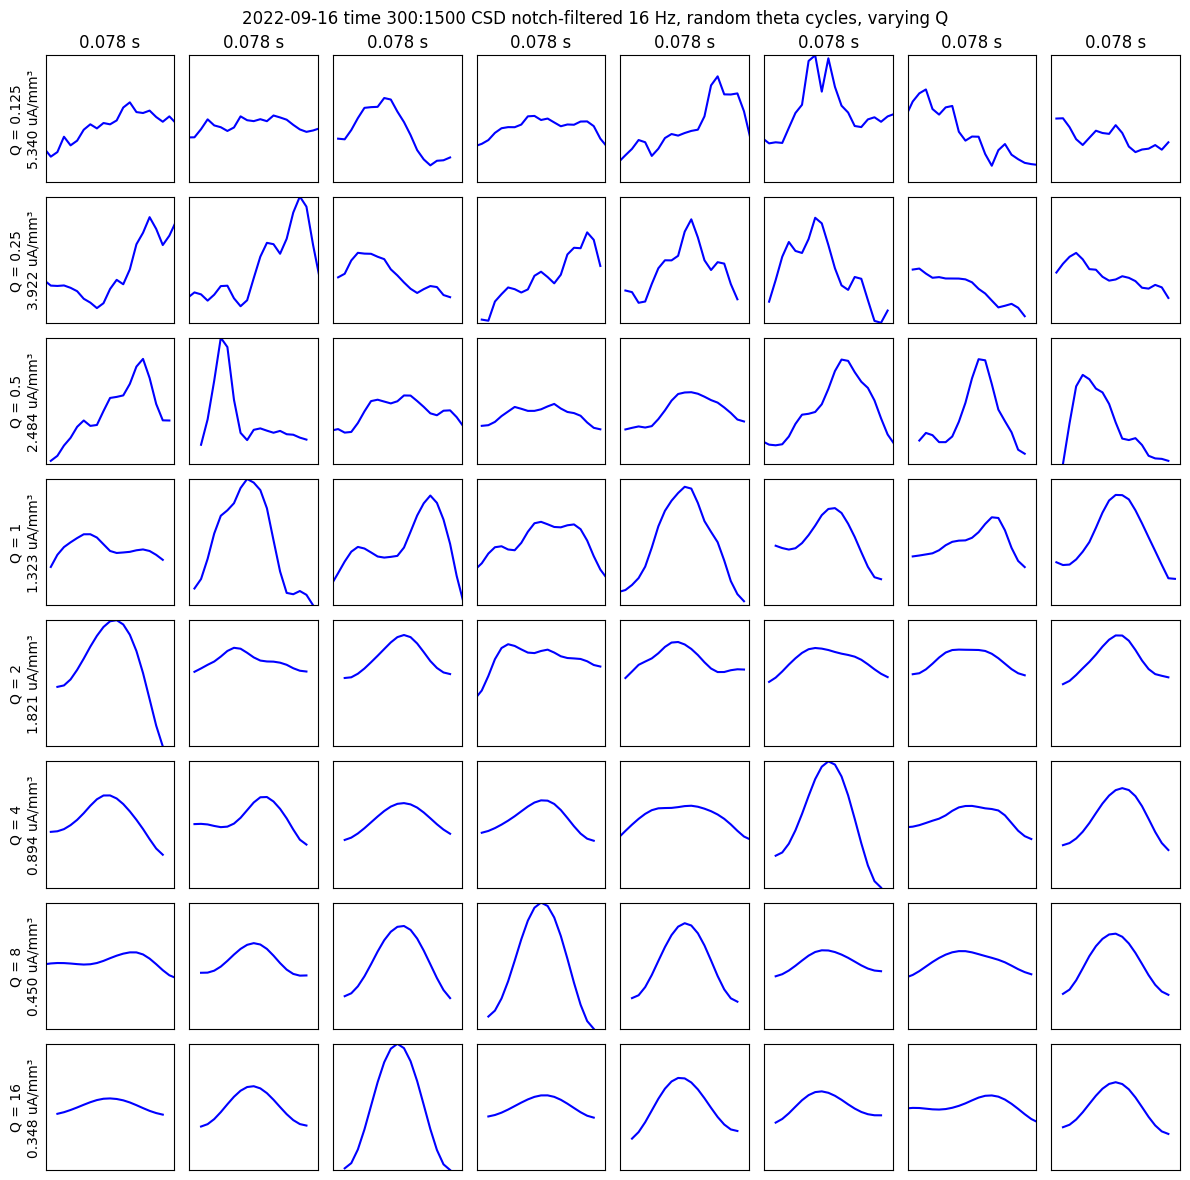

In [60]:
for freq in Fs:
    fig, ax = plt.subplots(8, 8, figsize=(12, 12))

    for i, q in enumerate(Qs):
        x = csd.values * 0.001 # [A/m^3 -> uA / mm^3]
        b, a = scipy.signal.iirnotch(w0=freq, Q=q, fs=1250)

        theta = x - scipy.signal.filtfilt(b, a, x, axis=0)
        phase = np.angle(scipy.signal.hilbert(theta))
        df = pd.DataFrame({
            'theta': theta,
            'phase': phase,
        }, index=csd.index)

        t1 = pd.date_range(start=0, periods=len(df), freq='0.8ms')
        t2 = pd.date_range(start=0, periods=len(df) // 5, freq='4ms')
        tmp = df.set_index(t1)
        tmp = tmp.reindex(t2).interpolate(method='linear')
        df = tmp.set_index(df.index[::5])

        cycle = np.cumsum(df.phase.diff() < -0.5) - 1
        step = cycle.groupby(cycle).cumcount()
        step[cycle == -1] -1
        df = pd.DataFrame({
            'theta': df.theta,
            'phase': df.phase,
            'cycle': cycle,
            'step': step,
        })

        ylim = [0, 0]
        for j in range(8):
            while True:
                cycle = np.random.randint(0, 9000)
                x = df[df.cycle == cycle].theta
                long_enough = len(x) >= 1 / MAX_THETA * 250
                short_enough = len(x) <= 1 / MIN_THETA * 250
                if long_enough and short_enough:
                    break
            t = x.index[len(x) // 2]
            ylim = min(x.min(), ylim[0]), max(x.max(), ylim[1])

            plt.sca(ax[i][j])
            plt.plot(x, 'b')
            window = 1.25 / freq
            plt.xlim([t - window / 2, t + window / 2])
            plt.yticks([])
            plt.xticks([])
            plt.ylabel('')
            plt.xlabel('')

        for j in range(8):
            plt.sca(ax[i][j])
            plt.ylim(ylim)
            if j == 0:
                axlim = f'{ylim[1] - ylim[0]:0.3f} uA/mm\u00b3'
                plt.ylabel(f'Q = {q}\n{axlim}')
            if i == 0:
                plt.title(f'{window:0.3f} s')

    plt.suptitle(f'{date} time {start}:{end} CSD notch-filtered {freq} Hz, random theta cycles, varying Q')
    plt.tight_layout()
    plt.savefig(f'{date}-time-{start}-{end}-csd-notch-{freq}-sample-cycles.png', dpi=200)
    plt.show()

---

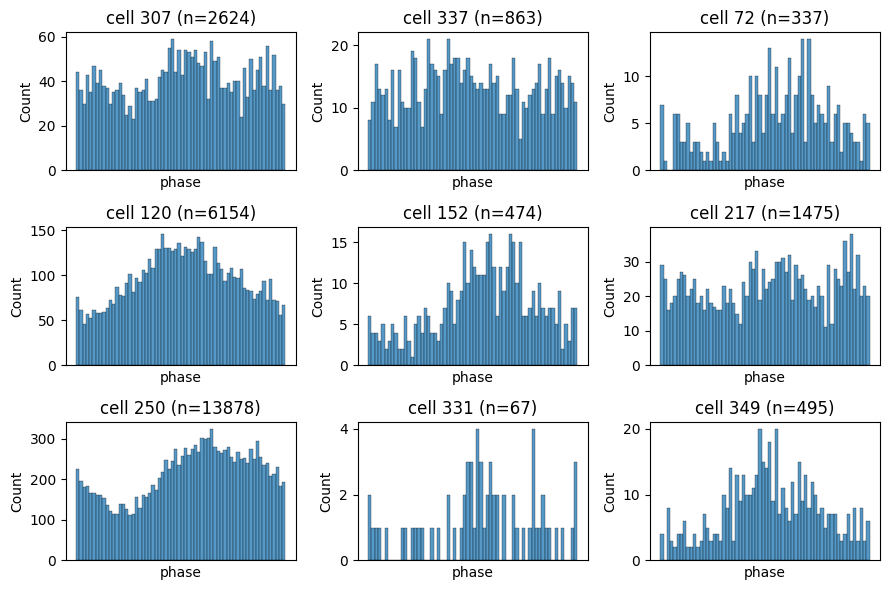

In [139]:
fig, ax = plt.subplots(3, 3, figsize=(9, 6))
for i in range(9):
    plt.sca(ax.flat[i])
    sns.histplot(df.phase[df[counts.index[i]] > 0], bins=64)
    plt.title(f'cell {counts.index[i]} (n={counts.iloc[i]})')
    plt.xticks([])
plt.tight_layout()
plt.show()